In [30]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('dataset/data/all_accelerometer_data_pids_13.csv')
df.tail()

,time,pid,x,y,z
14057562,1493829248196,CC6740,-0.133956,0.124726,-0.010736
14057563,1493829248220,CC6740,-0.100764,0.180872,0.046449
14057564,1493829248245,CC6740,-0.131853,0.195934,0.181088
14057565,1493829248270,CC6740,-0.149704,0.194482,0.202393
14057566,1493829248294,CC6740,-0.107288,0.153548,0.168595


In [3]:
accel_df = pd.DataFrame(df)


# The timestamp appears to be in milliseconds. Convert to datetime.
accel_df['datetime'] = pd.to_datetime(accel_df['time'], unit='ms')

# Set datetime as the index for time-series operations
accel_df.set_index('datetime', inplace=True)

print("Accelerometer Data Loaded and Cleaned:")
print(accel_df.head())

Accelerometer Data Loaded and Cleaned:
                                  time     pid       x       y       z
datetime                                                              
1970-01-01 00:00:00.000              0  JB3156  0.0000  0.0000  0.0000
1970-01-01 00:00:00.000              0  CC6740  0.0000  0.0000  0.0000
2017-05-02 14:04:42.409  1493733882409  SA0297  0.0758  0.0273 -0.0102
2017-05-02 14:04:42.455  1493733882455  SA0297 -0.0359  0.0794  0.0037
2017-05-02 14:04:42.500  1493733882500  SA0297 -0.2427 -0.0861 -0.0163


In [5]:
import pandas as pd
import glob
import os

large_data_filepath = 'dataset/data/all_accelerometer_data_pids_13.csv'
chunk_size = 500000  # Process 500,000 rows at a time. Adjust based on your RAM.
all_features_list = [] # A list to store the results from each chunk

# The pd.read_csv function returns an iterator that yields one chunk at a time
chunk_iterator = pd.read_csv(
    large_data_filepath,
    chunksize=chunk_size,
    dtype={'time': 'int64', 'pid': 'object', 'x': 'float64', 'y': 'float64', 'z': 'float64'}
)

for i, chunk in enumerate(chunk_iterator):
    
    chunk.dropna(inplace=True)
    chunk['datetime'] = pd.to_datetime(chunk['time'], unit='ms')
    chunk.set_index('datetime', inplace=True)

    window_size = '2.5s'
    aggregations = {
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'z': ['mean', 'std', 'min', 'max']
    }

    # Perform the feature engineering on the current chunk
    chunk_features = (
        chunk
        .groupby('pid')
        .resample(window_size)
        .agg(aggregations)
    )
    
    # Flatten column names and reset index
    chunk_features.columns = ['_'.join(col).strip() for col in chunk_features.columns.values]
    chunk_features.reset_index(inplace=True)
    
    # Add the processed chunk's results to our list
    all_features_list.append(chunk_features)

# Combine the results from all chunks into a single final DataFrame
features_df = pd.concat(all_features_list, ignore_index=True)

print(features_df.head())
features_df.info()

Starting: Processing the large dataset in chunks...
      pid                datetime    x_mean     x_std   x_min   x_max  \
0  BK7610 2017-05-02 14:37:50.000  0.057272  0.036508  0.0092  0.1443   
1  BK7610 2017-05-02 14:37:52.500  0.007218  0.036118 -0.0893  0.1291   
2  BK7610 2017-05-02 14:37:55.000 -0.004987  0.021808 -0.1092  0.0556   
3  BK7610 2017-05-02 14:37:57.500 -0.000763  0.023271 -0.0725  0.0663   
4  BK7610 2017-05-02 14:38:00.000  0.001328  0.021138 -0.0372  0.0670   

     y_mean     y_std   y_min   y_max    z_mean     z_std   z_min   z_max  
0 -0.004174  0.034734 -0.0779  0.1069  0.003019  0.068382 -0.1963  0.1585  
1 -0.001902  0.043753 -0.1888  0.0839  0.016024  0.067733 -0.1821  0.2526  
2  0.007886  0.031792 -0.0591  0.1151  0.010213  0.046734 -0.1404  0.2188  
3  0.005206  0.027082 -0.0969  0.0798  0.006843  0.044047 -0.1074  0.1204  
4  0.004925  0.045561 -0.1068  0.1015  0.007109  0.042403 -0.1310  0.0919  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172

In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172950 entries, 0 to 172949
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   pid       172950 non-null  object        
 1   datetime  172950 non-null  datetime64[ns]
 2   x_mean    149949 non-null  float64       
 3   x_std     149896 non-null  float64       
 4   x_min     149949 non-null  float64       
 5   x_max     149949 non-null  float64       
 6   y_mean    149949 non-null  float64       
 7   y_std     149896 non-null  float64       
 8   y_min     149949 non-null  float64       
 9   y_max     149949 non-null  float64       
 10  z_mean    149949 non-null  float64       
 11  z_std     149896 non-null  float64       
 12  z_min     149949 non-null  float64       
 13  z_max     149949 non-null  float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 18.5+ MB


In [7]:
# The filenames are expected to follow the pattern '...CAM Results.xlsx - Client Report.csv'
all_files = glob.glob('dataset/data/raw_tac/*CAM Results.xlsx') 

# List to hold individual DataFrames
li = []

for filename in all_files:
    # Read the Excel file, skipping the first row which is a superfluous header
    df_participant = pd.read_excel(filename, skiprows=1)
    
    # Extract the participant ID (pid) from the filename
    pid = os.path.basename(filename).split(' ')[0]
    
    # Add the pid as a new column to preserve data provenance
    df_participant['pid'] = pid
    
    li.append(df_participant)

# Concatenate all DataFrames in the list into a single master DataFrame
df_master = pd.concat(li, axis=0, ignore_index=True) 

In [8]:
print(df_master.shape)

(713, 17)


In [9]:
print(df_master.head())

   TAC Level  Unnamed: 1  Unnamed: 2  IR Voltage  Unnamed: 4  Unnamed: 5  \
0        0.0         NaN         NaN       1.127         NaN         NaN   
1        0.0         NaN         NaN       1.121         NaN         NaN   
2        0.0         NaN         NaN       1.069         NaN         NaN   
3        0.0         NaN         NaN       1.060         NaN         NaN   
4        0.0         NaN         NaN       1.108         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Temperature  Unnamed: 9  Unnamed: 10  \
0         NaN         NaN       74.955         NaN          NaN   
1         NaN         NaN       74.955         NaN          NaN   
2         NaN         NaN       76.627         NaN          NaN   
3         NaN         NaN       77.371         NaN          NaN   
4         NaN         NaN       77.929         NaN          NaN   

                 Time  Unnamed: 12  Unnamed: 13  Unnamed: 14  \
0 2017-05-02 10:36:54          NaN          NaN          NaN   
1 2017-05-02

In [10]:
print(df_master.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TAC Level    713 non-null    float64       
 1   Unnamed: 1   0 non-null      float64       
 2   Unnamed: 2   0 non-null      float64       
 3   IR Voltage   713 non-null    float64       
 4   Unnamed: 4   0 non-null      float64       
 5   Unnamed: 5   0 non-null      float64       
 6   Unnamed: 6   0 non-null      float64       
 7   Unnamed: 7   0 non-null      float64       
 8   Temperature  713 non-null    float64       
 9   Unnamed: 9   0 non-null      float64       
 10  Unnamed: 10  0 non-null      float64       
 11  Time         713 non-null    datetime64[ns]
 12  Unnamed: 12  0 non-null      float64       
 13  Unnamed: 13  0 non-null      float64       
 14  Unnamed: 14  0 non-null      float64       
 15  Date         713 non-null    datetime64[ns]
 16  pid     

In [11]:
df_master.dropna(axis=1, how='all', inplace=True)

df_master.rename(columns={
    'TAC Level': 'TAC_Level',
    'IR Voltage': 'IR_Voltage',
    'Temperature': 'Temperature'
}, inplace=True)

# Combine 'Date' and 'Time' columns into a single datetime object
print(df_master[['Date', 'Time']].head())

# Since 'Date' and 'Time' are the same and already full datetimes, just use 'Date'
df_master['datetime'] = pd.to_datetime(df_master['Date'], errors='coerce')

# Drop the original 'Date' and 'Time' columns
df_master.drop(['Date', 'Time'], axis=1, inplace=True)

# Set the new 'datetime' column as the index of the DataFrame
df_master.set_index('datetime', inplace=True)
df_master.sort_index(inplace=True)


                 Date                Time
0 2017-05-02 10:36:54 2017-05-02 10:36:54
1 2017-05-02 11:09:57 2017-05-02 11:09:57
2 2017-05-02 11:15:27 2017-05-02 11:15:27
3 2017-05-02 11:20:57 2017-05-02 11:20:57
4 2017-05-02 11:26:26 2017-05-02 11:26:26


In [12]:
print(df_master.shape)

(713, 4)


In [13]:
print(df_master.head())

                     TAC_Level  IR_Voltage  Temperature     pid
datetime                                                       
2017-05-02 10:03:43        0.0       1.126       72.302  SA0297
2017-05-02 10:22:39        0.0       1.054       78.364  PC6771
2017-05-02 10:34:06        0.0       0.977       74.161  SA0297
2017-05-02 10:36:54        0.0       1.127       74.955  BK7610
2017-05-02 10:39:23        0.0       1.081       75.834  SA0297


In [14]:
print(df_master.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2017-05-02 10:03:43 to 2017-05-03 12:19:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TAC_Level    713 non-null    float64
 1   IR_Voltage   713 non-null    float64
 2   Temperature  713 non-null    float64
 3   pid          713 non-null    object 
dtypes: float64(3), object(1)
memory usage: 27.9+ KB
None


In [15]:
# Check for missing values in the DataFrame
print(df_master.isnull().sum())

TAC_Level      0
IR_Voltage     0
Temperature    0
pid            0
dtype: int64


In [16]:
# Load the phone type metadata
df_phone_types = pd.read_csv('dataset/data/phone_types.csv') 

# Convert the 'datetime' index back into a regular column before merging.
df_master.reset_index(inplace=True)

# This uses the 'pid' column as the key to join on
df_final = pd.merge(df_master, df_phone_types, on='pid', how='left') 

# Final Dataset
df_final.info()
print("\nFirst 5 rows of the final prepared dataset:")
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     713 non-null    datetime64[ns]
 1   TAC_Level    713 non-null    float64       
 2   IR_Voltage   713 non-null    float64       
 3   Temperature  713 non-null    float64       
 4   pid          713 non-null    object        
 5   phonetype    713 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 33.6+ KB

First 5 rows of the final prepared dataset:
             datetime  TAC_Level  IR_Voltage  Temperature     pid phonetype
0 2017-05-02 10:03:43        0.0       1.126       72.302  SA0297    iPhone
1 2017-05-02 10:22:39        0.0       1.054       78.364  PC6771    iPhone
2 2017-05-02 10:34:06        0.0       0.977       74.161  SA0297    iPhone
3 2017-05-02 10:36:54        0.0       1.127       74.955  BK7610    iPhone
4 2017-

        TAC_Level  Temperature  IR_Voltage
count  713.000000   713.000000  713.000000
mean     0.046226    84.361725    1.053010
std      0.065822     7.735502    0.133195
min      0.000000    65.583000    0.670000
25%      0.000000    78.622000    0.950000
50%      0.016000    82.429000    1.052000
75%      0.068000    91.416000    1.149000
max      0.437000   101.251000    1.849000


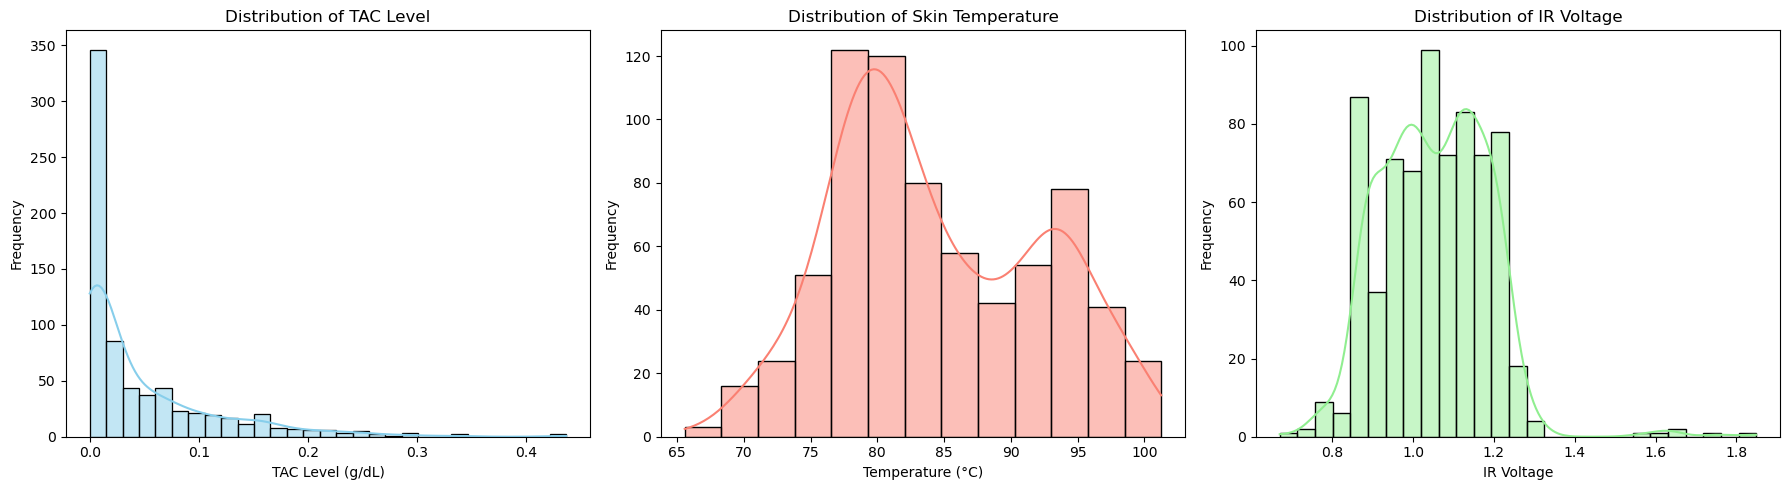

In [17]:
# Univariate Analysis and Visualization
print(df_final[['TAC_Level', 'Temperature', 'IR_Voltage']].describe())

# Plot histograms to see the distribution of key variables
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_final['TAC_Level'], kde=True, color='skyblue')
plt.title('Distribution of TAC Level')
plt.xlabel('TAC Level (g/dL)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df_final['Temperature'], kde=True, color='salmon')
plt.title('Distribution of Skin Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df_final['IR_Voltage'], kde=True, color='lightgreen')
plt.title('Distribution of IR Voltage')
plt.xlabel('IR Voltage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
print(df_final[['TAC_Level', 'Temperature', 'IR_Voltage']].describe())


        TAC_Level  Temperature  IR_Voltage
count  713.000000   713.000000  713.000000
mean     0.046226    84.361725    1.053010
std      0.065822     7.735502    0.133195
min      0.000000    65.583000    0.670000
25%      0.000000    78.622000    0.950000
50%      0.016000    82.429000    1.052000
75%      0.068000    91.416000    1.149000
max      0.437000   101.251000    1.849000


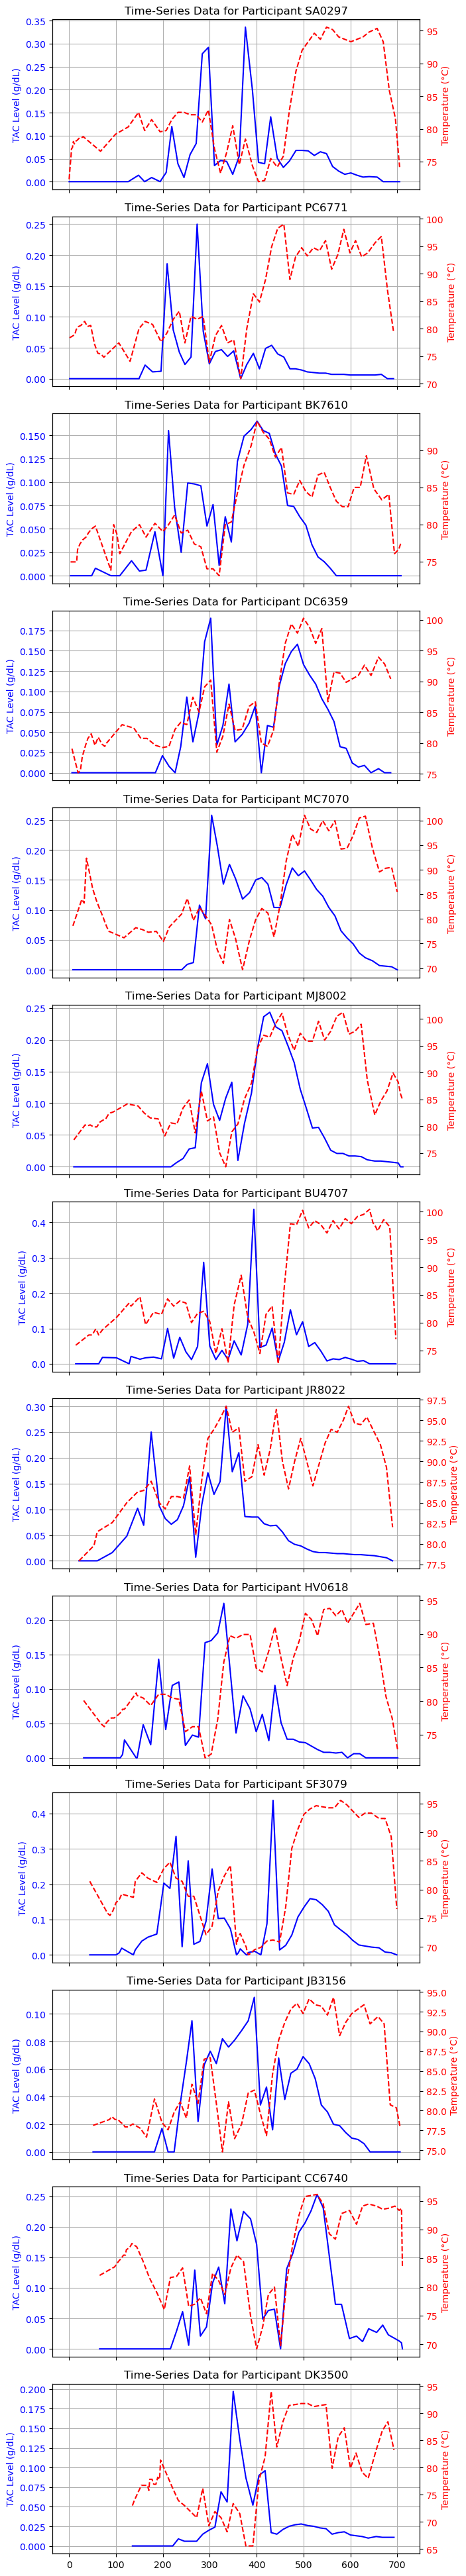

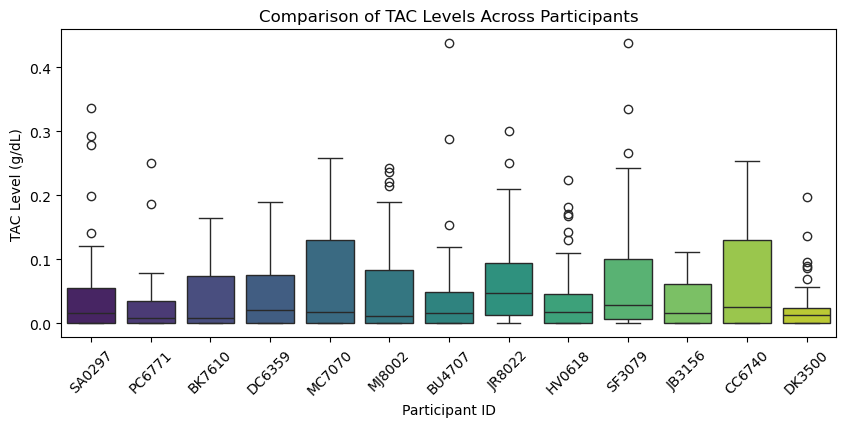

In [19]:
# Temporal Analysis 
# Plot time-series data for each participant
pids = df_final['pid'].unique()
num_pids = len(pids)

fig, axes = plt.subplots(num_pids, 1, figsize=(7, 3 * num_pids), sharex=True)
if num_pids == 1: # Matplotlib returns a single axes object if only one subplot
    axes = [axes]

for i, pid in enumerate(pids):
    participant_data = df_final[df_final['pid'] == pid]
    ax = axes[i]
    
    ax.plot(participant_data.index, participant_data['TAC_Level'], label='TAC Level', color='blue')
    ax.set_ylabel('TAC Level (g/dL)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax.twinx()
    ax2.plot(participant_data.index, participant_data['Temperature'], label='Temperature', color='red', linestyle='--')
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(f'Time-Series Data for Participant {pid}')
    ax.grid(True)

fig.tight_layout()
plt.show()

# Box plots to compare TAC levels across participants
plt.figure(figsize=(10, 4))
sns.boxplot(x='pid', y='TAC_Level', data=df_final,hue='pid', palette='viridis')
plt.title('Comparison of TAC Levels Across Participants')
plt.xlabel('Participant ID')
plt.ylabel('TAC Level (g/dL)')
plt.xticks(rotation=45)
plt.show()



--- Correlation Matrix ---
             TAC_Level  Temperature  IR_Voltage
TAC_Level     1.000000     0.138379    0.031216
Temperature   0.138379     1.000000   -0.171122
IR_Voltage    0.031216    -0.171122    1.000000


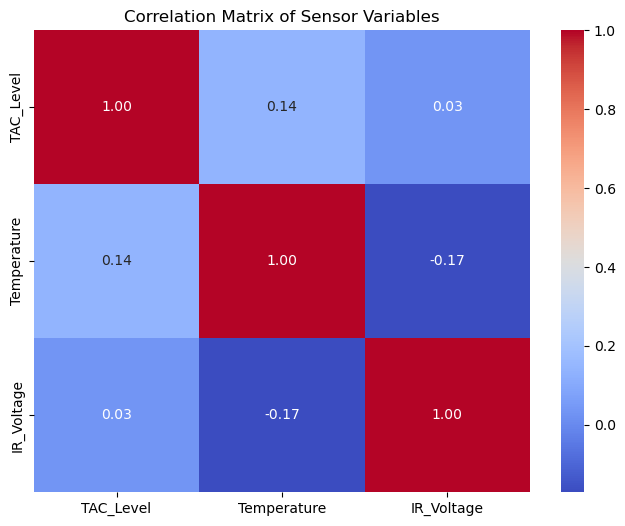

In [20]:
# Correlation matrix and heatmap
correlation_matrix = df_final[['TAC_Level', 'Temperature', 'IR_Voltage']].corr()
print("\n--- Correlation Matrix ---")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sensor Variables')
plt.show()

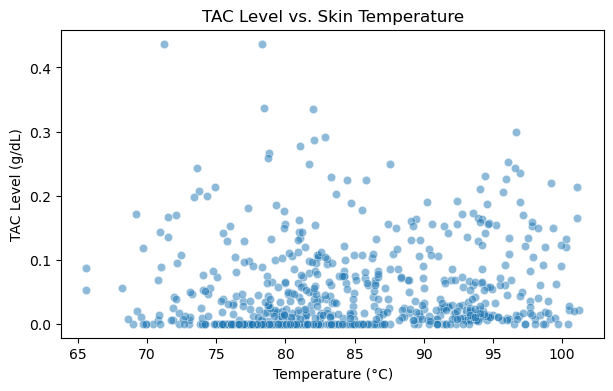

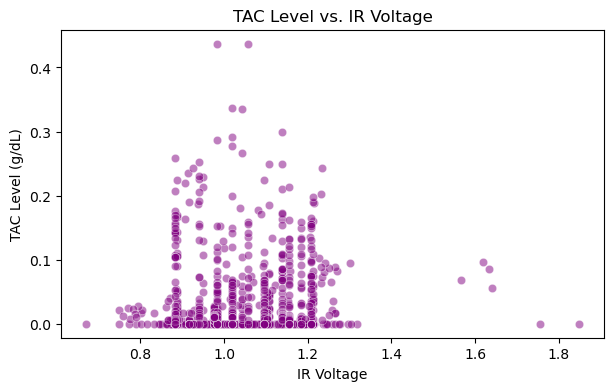

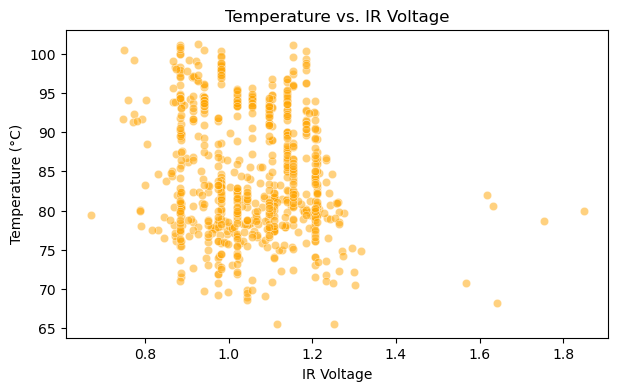

In [21]:
# Scatter plot of TAC Level vs. Temperature
plt.figure(figsize=(7, 4))
sns.scatterplot(x='Temperature', y='TAC_Level', data=df_final, alpha=0.5)
plt.title('TAC Level vs. Skin Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('TAC Level (g/dL)')
plt.show()

# Scatter plot of TAC Level vs. IR Voltage
plt.figure(figsize=(7, 4))
sns.scatterplot(x='IR_Voltage', y='TAC_Level', data=df_final, alpha=0.5, color='purple')
plt.title('TAC Level vs. IR Voltage')
plt.xlabel('IR Voltage')
plt.ylabel('TAC Level (g/dL)')
plt.show()

# Scatter plot of Temperature vs. IR Voltage
plt.figure(figsize=(7, 4))
sns.scatterplot(x='IR_Voltage', y='Temperature', data=df_final, alpha=0.5, color='orange')
plt.title('Temperature vs. IR Voltage')
plt.xlabel('IR Voltage')
plt.ylabel('Temperature (°C)')
plt.show()

c:\Users\harir\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


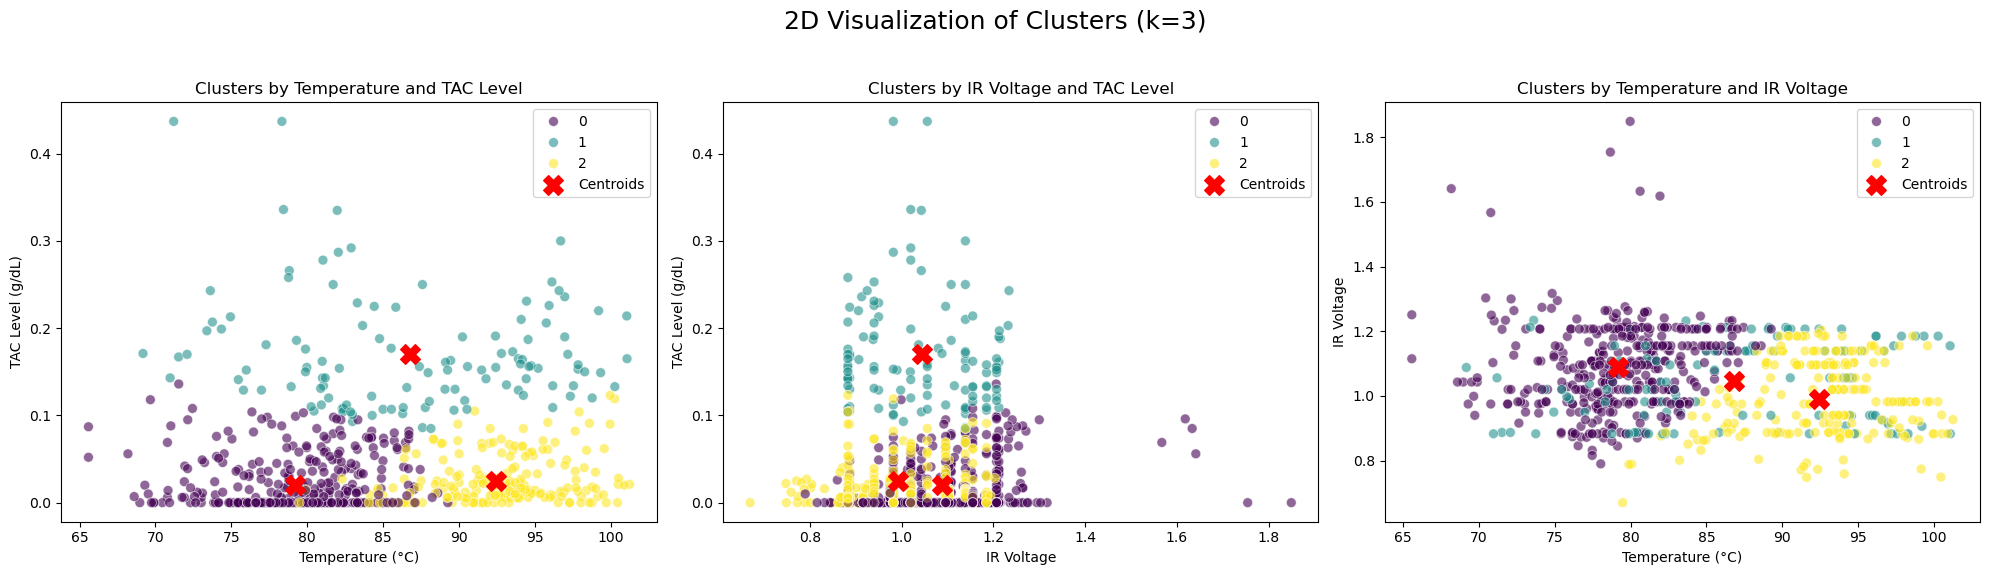

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
os.environ["OMP_NUM_THREADS"] = "3"

# Select the features for clustering
features = ['TAC_Level', 'Temperature', 'IR_Voltage']
cluster_data = df_final[features].dropna()

# Scale the data 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Apply K-Means (assuming k=3 from the Elbow Method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
cluster_data['Cluster'] = cluster_labels

# Get the coordinates of the cluster centers
# We need to inverse_transform them back to the original scale for plotting
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

# Visualize the Clusters in 2D
plt.figure(figsize=(20, 6))
plt.suptitle(f'2D Visualization of Clusters (k={optimal_k})', fontsize=18)

# Plot 1: Temperature vs. TAC Level
plt.subplot(1, 3, 1)
sns.scatterplot(x=cluster_data['Temperature'], y=cluster_data['TAC_Level'], hue=cluster_data['Cluster'],
                palette='viridis', alpha=0.6, s=50)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters by Temperature and TAC Level')
plt.xlabel('Temperature (°C)')
plt.ylabel('TAC Level (g/dL)')
plt.legend()

# Plot 2: IR Voltage vs. TAC Level
plt.subplot(1, 3, 2)
sns.scatterplot(x=cluster_data['IR_Voltage'], y=cluster_data['TAC_Level'], hue=cluster_data['Cluster'],
                palette='viridis', alpha=0.6, s=50)
plt.scatter(centroids[:, 2], centroids[:, 0], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters by IR Voltage and TAC Level')
plt.xlabel('IR Voltage')
plt.ylabel('TAC Level (g/dL)')
plt.legend()

# Plot 3: Temperature vs. IR Voltage
plt.subplot(1, 3, 3)
sns.scatterplot(x=cluster_data['Temperature'], y=cluster_data['IR_Voltage'], hue=cluster_data['Cluster'],
                palette='viridis', alpha=0.6, s=50)
plt.scatter(centroids[:, 1], centroids[:, 2], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters by Temperature and IR Voltage')
plt.xlabel('Temperature (°C)')
plt.ylabel('IR Voltage')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

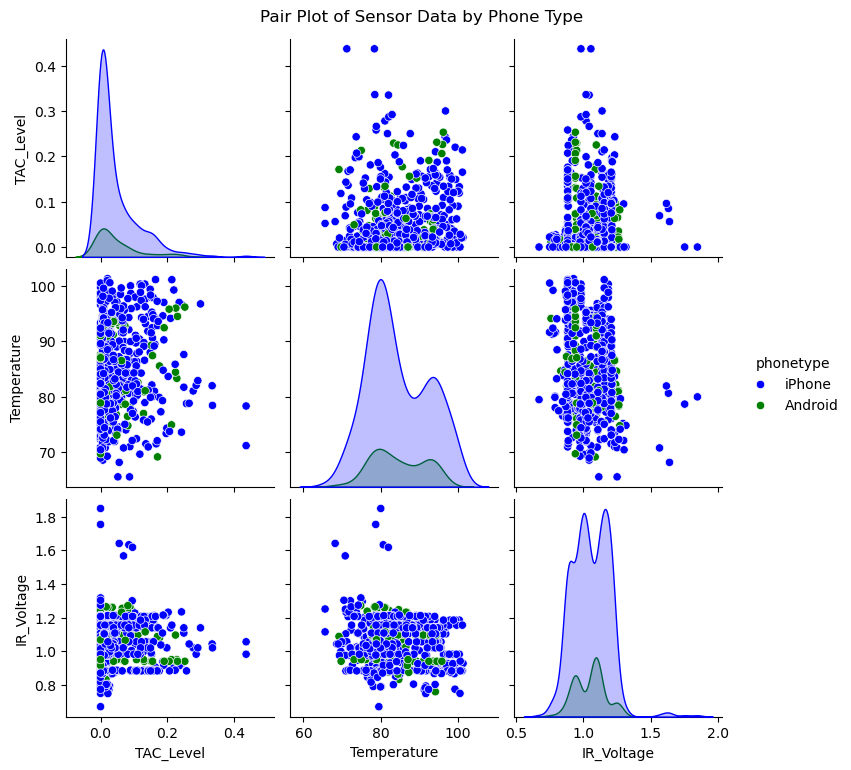

In [23]:
# Using Pair Plots for a Comprehensive View 
pairplot_data = df_final[['TAC_Level', 'Temperature', 'IR_Voltage', 'phonetype']].dropna()
n_samples = min(1000, len(pairplot_data))
pairplot_data = pairplot_data.sample(n=n_samples, random_state=1)

sns.pairplot(pairplot_data, hue='phonetype', palette={'Android': 'green', 'iPhone': 'blue'}, diag_kind='kde')
plt.suptitle('Pair Plot of Sensor Data by Phone Type', y=1.02)
plt.show()

In [24]:
import statsmodels.api as sm
# Prepare data for the model (dropping rows with missing values)
model_data = df_final[['TAC_Level', 'Temperature', 'IR_Voltage']].dropna()
X = model_data[['Temperature', 'IR_Voltage']]
y = model_data['TAC_Level']

# Add a constant (intercept) to the predictors
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              TAC_Level   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     8.080
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           0.000339
Time:                        16:33:01   Log-Likelihood:                 936.75
No. Observations:                 713   AIC:                            -1867.
Df Residuals:                     710   BIC:                            -1854.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0895      0.036     -2.479      

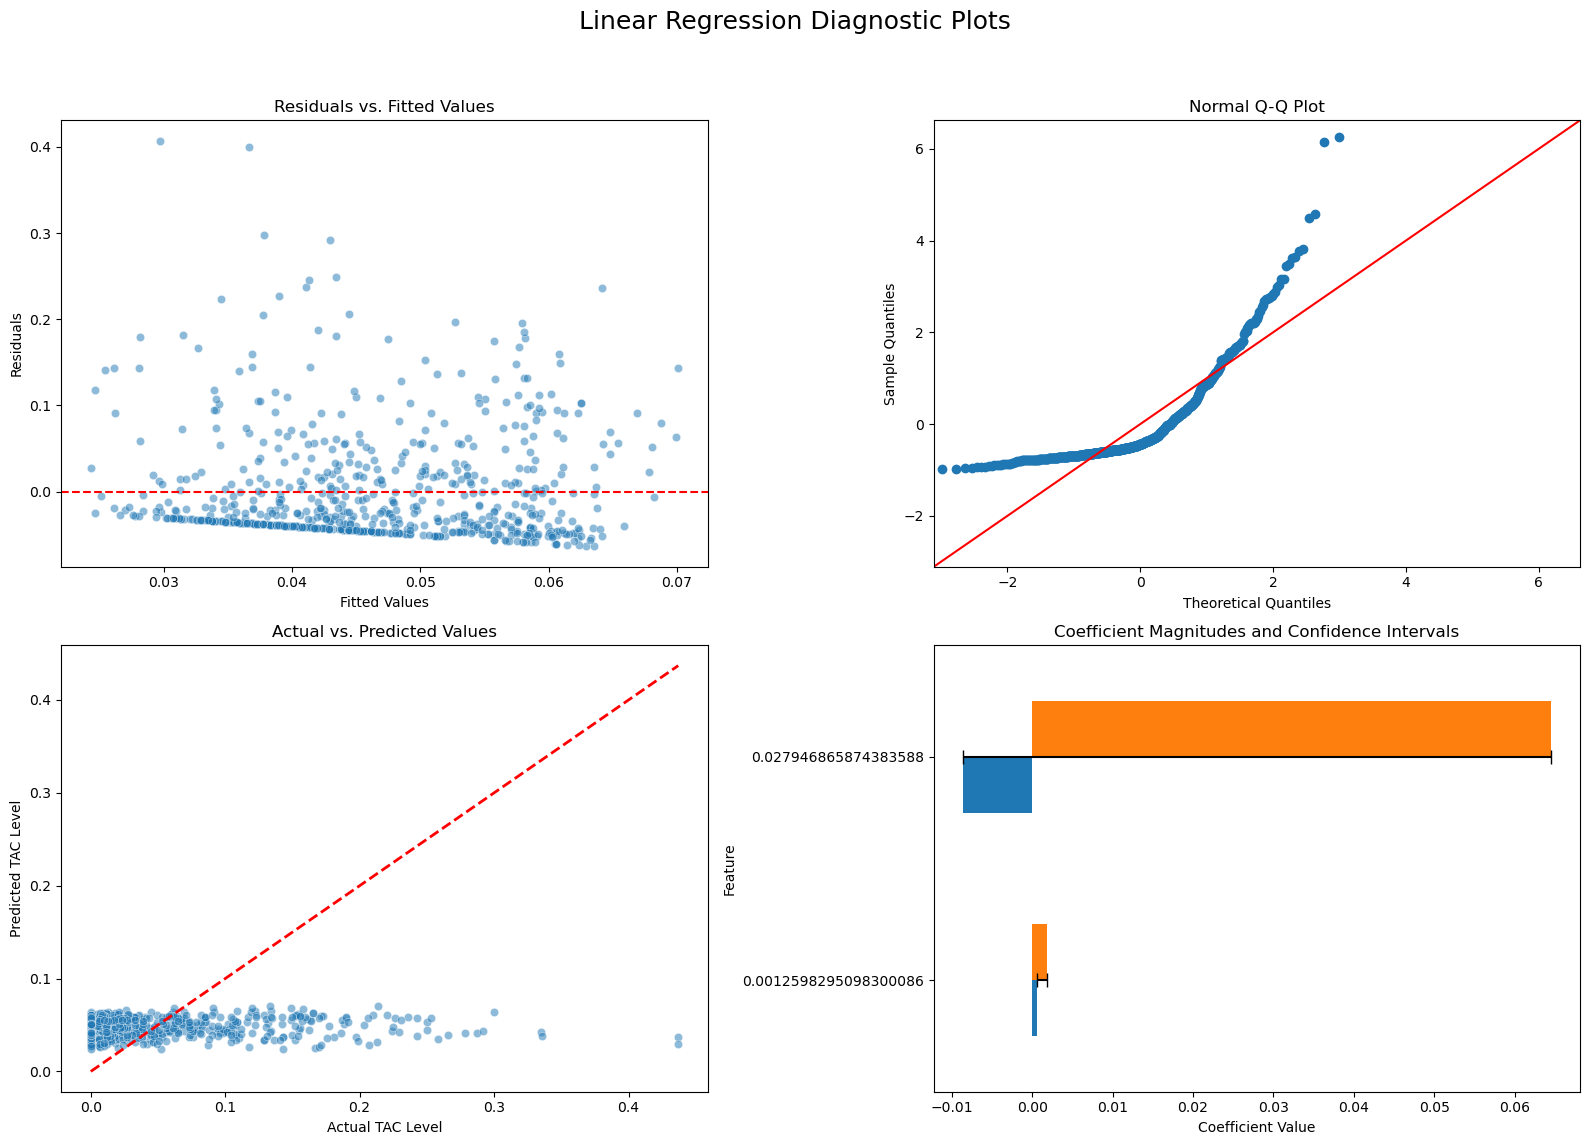

In [25]:
# Get model predictions and residuals
fitted_vals = model.predict()
residuals = model.resid

# --- 3. Regression Diagnostic Plots ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Linear Regression Diagnostic Plots', fontsize=18)

# Plot 1: Residuals vs. Fitted Plot
sns.scatterplot(x=fitted_vals, y=residuals, ax=axes[0, 0], alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals vs. Fitted Values')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')

# Plot 2: Normal Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# Plot 3: Actual vs. Predicted Plot
sns.scatterplot(x=y, y=fitted_vals, ax=axes[1, 0], alpha=0.5)
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1, 0].set_title('Actual vs. Predicted Values')
axes[1, 0].set_xlabel('Actual TAC Level')
axes[1, 0].set_ylabel('Predicted TAC Level')

# Plot 4: Coefficient Plot
coef_df = pd.DataFrame(model.params, columns=['Coefficient'])
coef_df['Conf_Int_Lower'] = model.conf_int()[0]
coef_df['Conf_Int_Upper'] = model.conf_int()[1]
coef_df = coef_df.drop('const') # Drop the constant for plotting
coef_df.plot(kind='barh', x='Coefficient', y=None, ax=axes[1, 1], legend=False)
axes[1, 1].errorbar(coef_df['Coefficient'], coef_df.index, 
                   xerr=(coef_df['Coefficient'] - coef_df['Conf_Int_Lower'], 
                         coef_df['Conf_Int_Upper'] - coef_df['Coefficient']),
                   fmt='none', c='black', capsize=5)
axes[1, 1].set_title('Coefficient Magnitudes and Confidence Intervals')
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_ylabel('Feature')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     713 non-null    datetime64[ns]
 1   TAC_Level    713 non-null    float64       
 2   IR_Voltage   713 non-null    float64       
 3   Temperature  713 non-null    float64       
 4   pid          713 non-null    object        
 5   phonetype    713 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 33.6+ KB


In [27]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172950 entries, 0 to 172949
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   pid       172950 non-null  object        
 1   datetime  172950 non-null  datetime64[ns]
 2   x_mean    149949 non-null  float64       
 3   x_std     149896 non-null  float64       
 4   x_min     149949 non-null  float64       
 5   x_max     149949 non-null  float64       
 6   y_mean    149949 non-null  float64       
 7   y_std     149896 non-null  float64       
 8   y_min     149949 non-null  float64       
 9   y_max     149949 non-null  float64       
 10  z_mean    149949 non-null  float64       
 11  z_std     149896 non-null  float64       
 12  z_min     149949 non-null  float64       
 13  z_max     149949 non-null  float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 18.5+ MB


In [28]:
# Sort both dataframes by time, which is required for merge_asof
features_df.sort_values('datetime', inplace=True)
df_final.sort_values('datetime', inplace=True)

# Merge the features DataFrame with the final dataset using merge_asof
final_df = pd.merge_asof(
    left=features_df,
    right=df_final,
    on='datetime',
    by='pid',
    direction='nearest',
    tolerance=pd.Timedelta('10min')
)

# Drop any rows where a TAC_Level match wasn't found
final_df.dropna(subset=['TAC_Level'], inplace=True)

print("\nFinal Merged Dataset:")
print(final_df.head())


Final Merged Dataset:
      pid                datetime    x_mean     x_std   x_min   x_max  \
2  SA0297 2017-05-02 14:04:40.000  0.019950  0.078984 -0.0359  0.0758   
3  SA0297 2017-05-02 14:04:42.500 -0.019256  0.050955 -0.2888  0.0076   
4  SA0297 2017-05-02 14:04:45.000  0.004220  0.038495 -0.1267  0.1672   
5  SA0297 2017-05-02 14:04:47.500 -0.002335  0.015642 -0.0506  0.0316   
6  SA0297 2017-05-02 14:04:50.000  0.000402  0.013892 -0.0322  0.0724   

     y_mean     y_std   y_min   y_max    z_mean     z_std   z_min   z_max  \
2  0.053350  0.036840  0.0273  0.0794 -0.003250  0.009829 -0.0102  0.0037   
3 -0.003724  0.017920 -0.0861  0.0514 -0.005207  0.011694 -0.0849  0.0134   
4  0.002442  0.043182 -0.0953  0.1881 -0.004798  0.023575 -0.0891  0.0841   
5  0.000109  0.008429 -0.0186  0.0254 -0.004773  0.047714 -0.1177  0.1393   
6 -0.001209  0.007405 -0.0324  0.0156 -0.000791  0.027351 -0.1269  0.0697   

   TAC_Level  IR_Voltage  Temperature phonetype  
2        0.0        1.02 

In [29]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96876 entries, 2 to 155375
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pid          96876 non-null  object        
 1   datetime     96876 non-null  datetime64[ns]
 2   x_mean       82431 non-null  float64       
 3   x_std        82400 non-null  float64       
 4   x_min        82431 non-null  float64       
 5   x_max        82431 non-null  float64       
 6   y_mean       82431 non-null  float64       
 7   y_std        82400 non-null  float64       
 8   y_min        82431 non-null  float64       
 9   y_max        82431 non-null  float64       
 10  z_mean       82431 non-null  float64       
 11  z_std        82400 non-null  float64       
 12  z_min        82431 non-null  float64       
 13  z_max        82431 non-null  float64       
 14  TAC_Level    96876 non-null  float64       
 15  IR_Voltage   96876 non-null  float64       
 16  Temperat

In [30]:
final_df.to_csv('dataset/data/final_merged_dataset.csv', index=False)

In [19]:
try:
    import tensorflow as tf
    import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
    DL_AVAILABLE = True
    print("Deep Learning libraries (TensorFlow) loaded successfully.")
except ImportError:
    DL_AVAILABLE = False
    print("Warning: TensorFlow not found")

Deep Learning libraries (TensorFlow) loaded successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, f1_score, confusion_matrix, r2_score, mean_squared_error, precision_score, recall_score
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Input, GRU, Dropout, Dense

In [ ]:
# Feature Selection and Data Splitting
features = ['x_mean', 'x_std', 'y_mean', 'y_std', 'z_mean', 'z_std']
target = 'TAC_Level'
df_clean = df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Data Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation (CPU) 
IMPAIRMENT_THRESHOLD = 0.08
y_test_class = (y_test > IMPAIRMENT_THRESHOLD).astype(int)

models_cpu = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest Regressor': RandomForestRegressor(n_jobs=-1, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

for name, model in models_cpu.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Regression metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Classification metrics
    y_pred_class = (y_pred > IMPAIRMENT_THRESHOLD).astype(int)
    precision = precision_score(y_test_class, y_pred_class, zero_division=0)
    recall = recall_score(y_test_class, y_pred_class, zero_division=0)
    f1 = f1_score(y_test_class, y_pred_class, zero_division=0)

    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")


Training set size: 65920 samples
Test set size: 16480 samples
Linear Regression:
  RMSE: 0.0673, MAE: 0.0503, R-squared: 0.0099
  Precision: 0.3387, Recall: 0.0258, F1-Score: 0.0480

Ridge Regression:
  RMSE: 0.0673, MAE: 0.0503, R-squared: 0.0095
  Precision: 0.3344, Recall: 0.0246, F1-Score: 0.0459

Random Forest Regressor:
  RMSE: 0.0571, MAE: 0.0364, R-squared: 0.2862
  Precision: 0.4734, Recall: 0.6385, F1-Score: 0.5437

Gradient Boosting Regressor:
  RMSE: 0.0574, MAE: 0.0387, R-squared: 0.2796
  Precision: 0.4432, Recall: 0.6316, F1-Score: 0.5209



In [29]:
# Deep Learning Models (LSTM & GRU)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM Model
from keras.layers import Input
lstm_model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])), # Explicit Input Layer
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_reshaped).flatten()

# Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
y_pred_lstm_class = (y_pred_lstm > IMPAIRMENT_THRESHOLD).astype(int)
precision_lstm = precision_score(y_test_class, y_pred_lstm_class, zero_division=0)
recall_lstm = recall_score(y_test_class, y_pred_lstm_class, zero_division=0)
f1_lstm = f1_score(y_test_class, y_pred_lstm_class, zero_division=0)

print("\nLSTM Model Performance:")
print(f"  RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R-squared: {r2_lstm:.4f}")
print(f"  Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1-Score: {f1_lstm:.4f}\n")

# GRU Model
gru_model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])), # Explicit Input Layer
    GRU(64, activation='relu'),
    Dropout(0.2), 
    Dense(32, activation='relu'), 
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0)
y_pred_gru = gru_model.predict(X_test_reshaped).flatten()

# Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
y_pred_gru_class = (y_pred_gru > IMPAIRMENT_THRESHOLD).astype(int)
precision_gru = precision_score(y_test_class, y_pred_gru_class, zero_division=0)
recall_gru = recall_score(y_test_class, y_pred_gru_class, zero_division=0)
f1_gru = f1_score(y_test_class, y_pred_gru_class, zero_division=0)

print("\nGRU Model Performance:")
print(f"  RMSE: {rmse_gru:.4f}, MAE: {mae_gru:.4f}, R-squared: {r2_gru:.4f}")
print(f"  Precision: {precision_gru:.4f}, Recall: {recall_gru:.4f}, F1-Score: {f1_gru:.4f}\n")

515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step

LSTM Model Performance:
  RMSE: 0.0625, MAE: 0.0461, R-squared: 0.1462
  Precision: 0.4392, Recall: 0.4371, F1-Score: 0.4382

515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step

GRU Model Performance:
  RMSE: 0.0623, MAE: 0.0454, R-squared: 0.1519
  Precision: 0.4342, Recall: 0.4995, F1-Score: 0.4646



In [25]:
# GPU-Accelerated Model Training (XGBoost) 

xgb_gpu_model = xgb.XGBRegressor(device = "cuda", objective='reg:squarederror', random_state=42)
xgb_gpu_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_gpu_model.predict(X_test_scaled)

# Regression Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Classification Metrics
y_pred_xgb_class = (y_pred_xgb > IMPAIRMENT_THRESHOLD).astype(int)
precision_xgb = precision_score(y_test_class, y_pred_xgb_class, zero_division=0)
recall_xgb = recall_score(y_test_class, y_pred_xgb_class, zero_division=0)
f1_xgb = f1_score(y_test_class, y_pred_xgb_class, zero_division=0)

print("XGBoost (GPU):")
print(f"  RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R-squared: {r2_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, F1-Score: {f1_xgb:.4f}\n")

# Hyperparameter Tuning on GPU (XGBoost)

param_grid_xgb = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_for_grid = xgb.XGBRegressor(device = "cuda", objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb_for_grid, param_grid=param_grid_xgb, scoring='r2', cv=3, verbose=1, n_jobs=-1
)
grid_search_xgb.fit(X_train_scaled, y_train)
print(f"\nBest Hyperparameters found for XGBoost (GPU): {grid_search_xgb.best_params_}")

# Final Tuned GPU Model Evaluation (XGBoost)
best_xgb_gpu = grid_search_xgb.best_estimator_
y_pred_final_gpu = best_xgb_gpu.predict(X_test_scaled)

# Regression metrics
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final_gpu))
final_mae = mean_absolute_error(y_test, y_pred_final_gpu)
final_r2 = r2_score(y_test, y_pred_final_gpu)

# Classification metrics
y_pred_final_gpu_class = (y_pred_final_gpu > IMPAIRMENT_THRESHOLD).astype(int)
final_precision = precision_score(y_test_class, y_pred_final_gpu_class, zero_division=0)
final_recall = recall_score(y_test_class, y_pred_final_gpu_class, zero_division=0)
final_f1 = f1_score(y_test_class, y_pred_final_gpu_class, zero_division=0)

print(f"Final Tuned XGBoost (GPU) Model Performance:")
print(f"  RMSE: {final_rmse:.4f}, MAE: {final_mae:.4f}, R-squared: {final_r2:.4f}")
print(f"  Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, F1-Score: {final_f1:.4f}\n")

XGBoost (GPU):
  RMSE: 0.0565, MAE: 0.0365, R-squared: 0.3011
  Precision: 0.4708, Recall: 0.6421, F1-Score: 0.5433

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best Hyperparameters found for XGBoost (GPU): {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Final Tuned XGBoost (GPU) Model Performance:
  RMSE: 0.0561, MAE: 0.0367, R-squared: 0.3128
  Precision: 0.4638, Recall: 0.6977, F1-Score: 0.5572



In [26]:
# Feature Importance 
feature_importances = pd.DataFrame(best_xgb_gpu.feature_importances_,
                                    index=features,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

        importance
y_std     0.375198
z_mean    0.306979
x_std     0.111934
x_mean    0.103603
z_std     0.054415
y_mean    0.047870


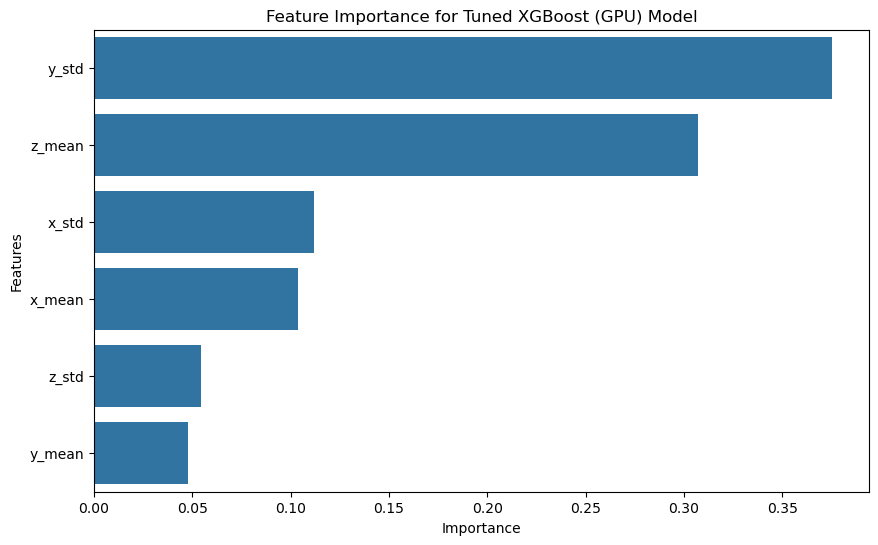

In [27]:
# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance for Tuned XGBoost (GPU) Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

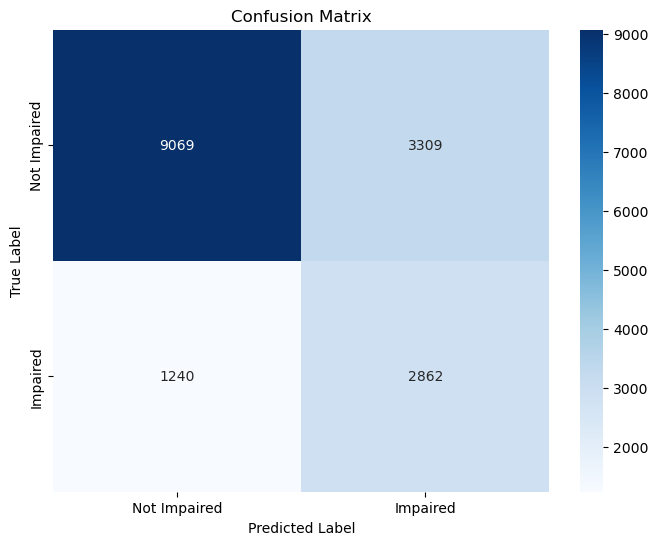

In [ ]:
# Confusion Matrix 
cm = confusion_matrix(y_test_class, y_pred_final_gpu_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Impaired', 'Impaired'], 
            yticklabels=['Not Impaired', 'Impaired'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()